In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [339]:
file_path = 'ds/DECADQ_74_previous-1950-2022.csv'
data = pd.read_csv(file_path, delimiter=";")

In [340]:
data.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMM,NUM_DECADE,RR,QRR,NBRR,...,QNEIGETOTM,NEIGETOTAB,QNEIGETOTAB,NEIGETOTABDAT,NBJNEIGETOT1,NBJNEIGETOT10,NBJNEIGETOT30,NBGREL,NBJORAG,NBJBROU
0,74001001,ABONDANCE,46.2845,6.734167,947,195001,1,78.4,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,74001001,ABONDANCE,46.2845,6.734167,947,195001,2,24.8,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,74001001,ABONDANCE,46.2845,6.734167,947,195001,3,18.6,9.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,74001001,ABONDANCE,46.2845,6.734167,947,195002,1,83.1,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,74001001,ABONDANCE,46.2845,6.734167,947,195002,2,56.4,9.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [341]:
data.describe()

,NUM_POSTE,LAT,LON,ALTI,AAAAMM,NUM_DECADE,RR,QRR,NBRR,RRAB,...,QNEIGETOTM,NEIGETOTAB,QNEIGETOTAB,NEIGETOTABDAT,NBJNEIGETOT1,NBJNEIGETOT10,NBJNEIGETOT30,NBGREL,NBJORAG,NBJBROU
count,1.315210e+05,131521.000000,131521.000000,131521.000000,131521.000000,131521.000000,126731.000000,126731.000000,131511.000000,126731.000000,...,58070.000000,58070.000000,58070.000000,23946.000000,58129.000000,58129.000000,58129.000000,131511.000000,28550.000000,25922.000000
mean,7.415114e+07,46.042651,6.463336,848.726941,198927.798587,2.000783,38.182292,1.475953,9.695600,17.729551,...,3.835354,20.568538,3.637661,15.257872,2.881660,2.311669,1.551618,1.754751,0.769247,0.695201
std,1.034983e+05,0.167798,0.290198,456.104228,2143.370664,0.816389,35.969416,1.891714,2.071162,14.578754,...,3.826713,44.622368,3.760872,8.911750,4.162301,3.965041,3.440570,3.821451,1.129559,1.298074
min,7.400100e+07,45.713000,5.841667,309.000000,195001.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.405642e+07,45.901667,6.255333,470.000000,197008.000000,1.000000,10.500000,1.000000,10.000000,6.600000,...,1.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.413600e+07,46.013000,6.483333,785.000000,199309.000000,2.000000,29.400000,1.000000,10.000000,15.000000,...,1.000000,0.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.423600e+07,46.168333,6.692833,1080.000000,200803.000000,3.000000,55.400000,1.000000,10.000000,25.400000,...,9.000000,18.000000,9.000000,22.000000,7.000000,3.000000,0.000000,0.000000,1.000000,1.000000
max,7.450000e+07,46.396500,6.970833,3845.000000,202212.000000,3.000000,407.300000,9.000000,11.000000,180.000000,...,9.000000,440.000000,9.000000,31.000000,11.000000,11.000000,11.000000,11.000000,8.000000,11.000000


In [342]:
data = data.drop(data[(data["AAAAMM"] >= 195001) & (data["AAAAMM"] <= 197912)].index)

In [343]:
# Fonction pour formater les dates AAAAMM en AAAA-MM-01
def format_date(aaaamm):
    return re.sub(r'(\d{4})(\d{2})', r'\1-\2-01', str(aaaamm))

# Liste des dates formatées
data["AAAAMM"] = [format_date(val) for val in data["AAAAMM"]]
data.rename(columns={"AAAAMM": "date"}, inplace=True)

In [407]:
aggregated_data = data.groupby("date").agg({
    'RR': 'mean',
    'QRR': 'sum',
    'NBRR': 'sum',          
    'NBJRR10': 'mean',    
    'NBJRR5': 'mean',     
    'NBJRR1': 'mean'      
})

aggregated_df = pd.DataFrame(aggregated_data)

print(aggregated_df)
#aggregated_df.to_csv("precipitation.csv")

                   RR    QRR    NBRR   NBJRR10    NBJRR5    NBJRR1
date                                                              
1980-01-01  52.778632  141.0  1209.0  1.940171  2.529915  4.111111
1980-02-01  39.864957  141.0  1131.0  1.324786  2.068376  3.324786
1980-03-01  50.132479  141.0  1209.0  2.153846  3.119658  5.145299
1980-04-01  10.667257  129.0  1129.0  0.176991  0.752212  2.469027
1980-05-01  43.789474  114.0  1178.0  1.719298  2.798246  4.438596
...               ...    ...     ...       ...       ...       ...
2022-08-01  25.391367  139.0  1431.0  0.956835  1.553957  2.424460
2022-09-01  55.087857  156.0  1382.0  1.757143  3.228571  5.092857
2022-10-01  43.111348  149.0  1434.0  1.375887  1.893617  3.063830
2022-11-01  44.897203  143.0  1389.0  1.734266  2.349650  4.489510
2022-12-01  60.846108  191.0  1627.0  2.143713  3.131737  4.604790

[516 rows x 6 columns]


In [408]:
aggregated_df = aggregated_df.reset_index()
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])
print(aggregated_df)

          date         RR    QRR    NBRR   NBJRR10    NBJRR5    NBJRR1
0   1980-01-01  52.778632  141.0  1209.0  1.940171  2.529915  4.111111
1   1980-02-01  39.864957  141.0  1131.0  1.324786  2.068376  3.324786
2   1980-03-01  50.132479  141.0  1209.0  2.153846  3.119658  5.145299
3   1980-04-01  10.667257  129.0  1129.0  0.176991  0.752212  2.469027
4   1980-05-01  43.789474  114.0  1178.0  1.719298  2.798246  4.438596
..         ...        ...    ...     ...       ...       ...       ...
511 2022-08-01  25.391367  139.0  1431.0  0.956835  1.553957  2.424460
512 2022-09-01  55.087857  156.0  1382.0  1.757143  3.228571  5.092857
513 2022-10-01  43.111348  149.0  1434.0  1.375887  1.893617  3.063830
514 2022-11-01  44.897203  143.0  1389.0  1.734266  2.349650  4.489510
515 2022-12-01  60.846108  191.0  1627.0  2.143713  3.131737  4.604790

[516 rows x 7 columns]


In [409]:
multiplicative_decomposition = seasonal_decompose(aggregated_df['RR'], model='multiplicative', period=12)

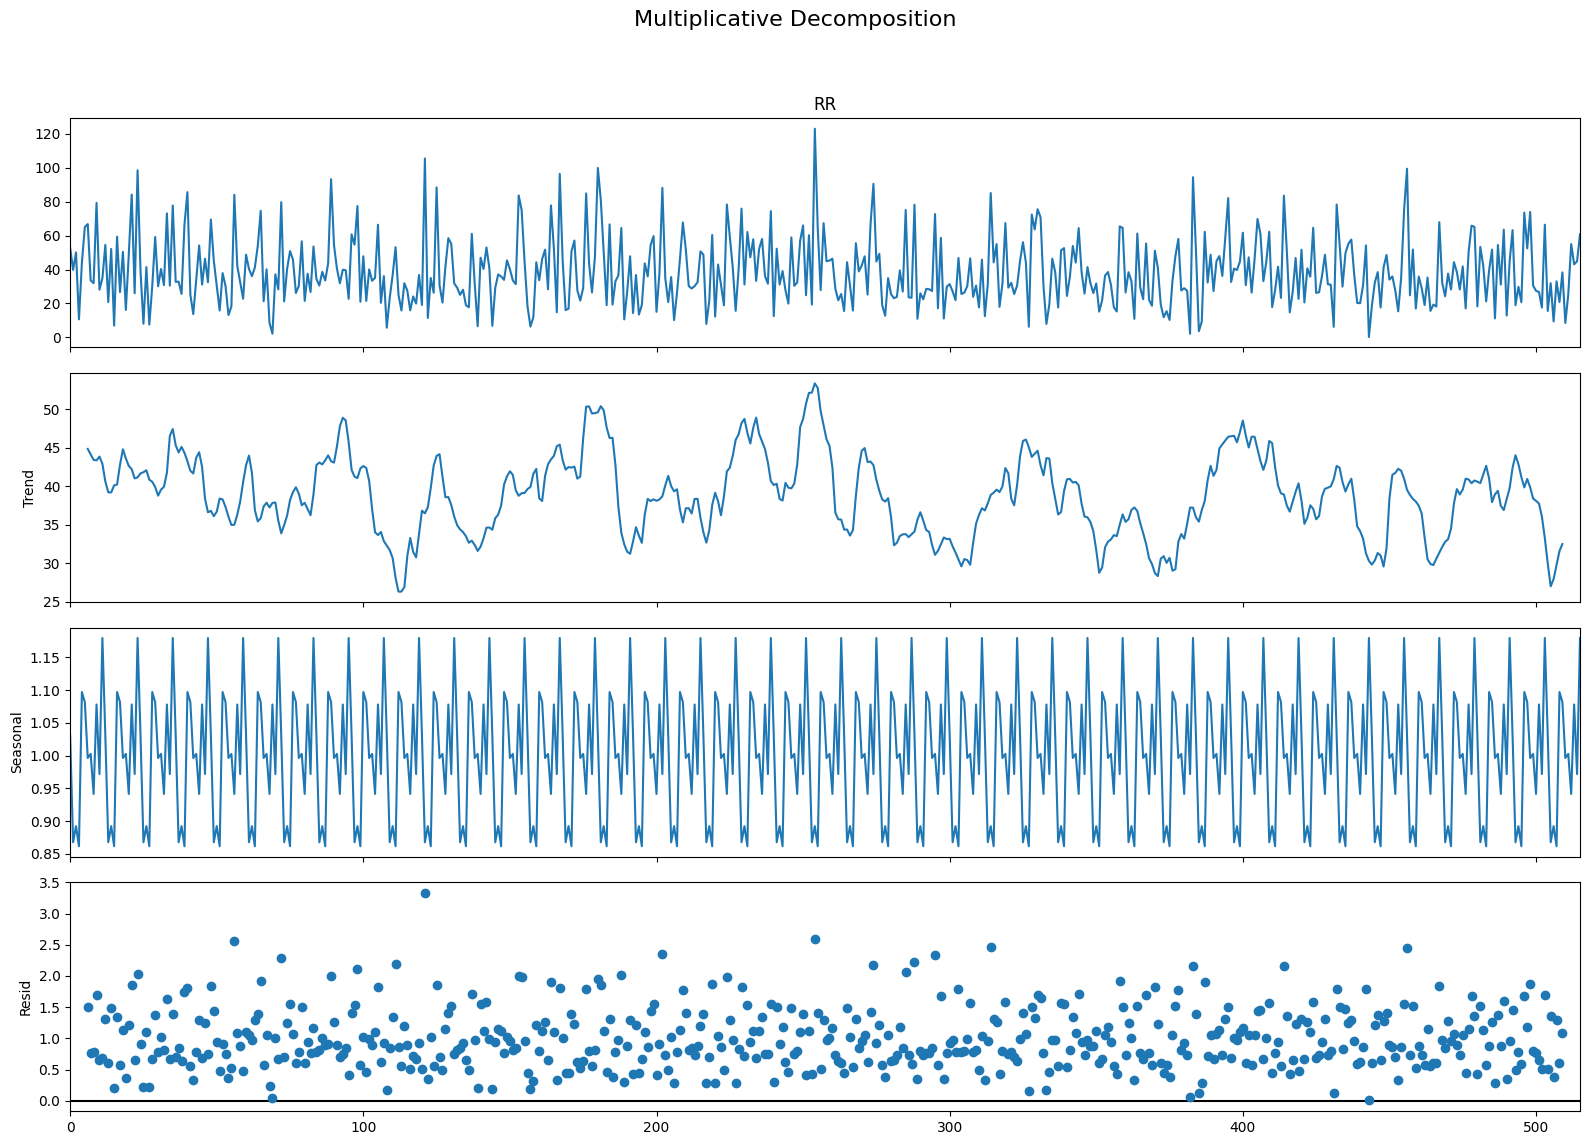

In [410]:
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [434]:
data_length = len(aggregated_df)
data_length

# Définir les indices pour diviser les données - 80% pour l'entraînement, 20% pour le test
train_size = int(data_length * 0.98)
test_size = data_length - train_size

In [435]:
# Préparer les séries d'apprentissage et de test
train_df = aggregated_df.iloc[:train_size]
test_df = aggregated_df.iloc[train_size:]

In [436]:
# Sélectionner la colonne 'RR' pour l'analyse
X_train = train_df['RR']
X_test = test_df['RR']

In [437]:
train_size, test_size

(505, 11)

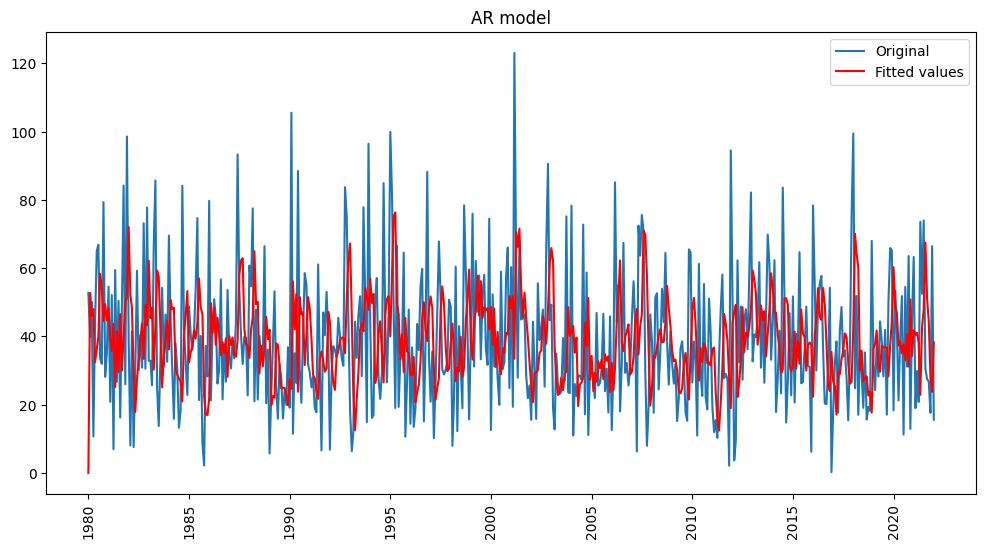

In [438]:
# Modèle ARI
model_AR = ARIMA(X_train, order=(2, 1, 0))  
results_AR = model_AR.fit()

# Préparer la visualisation pour le modèle ARI
plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['RR'], label='Original')
plt.plot(train_df['date'], results_AR.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

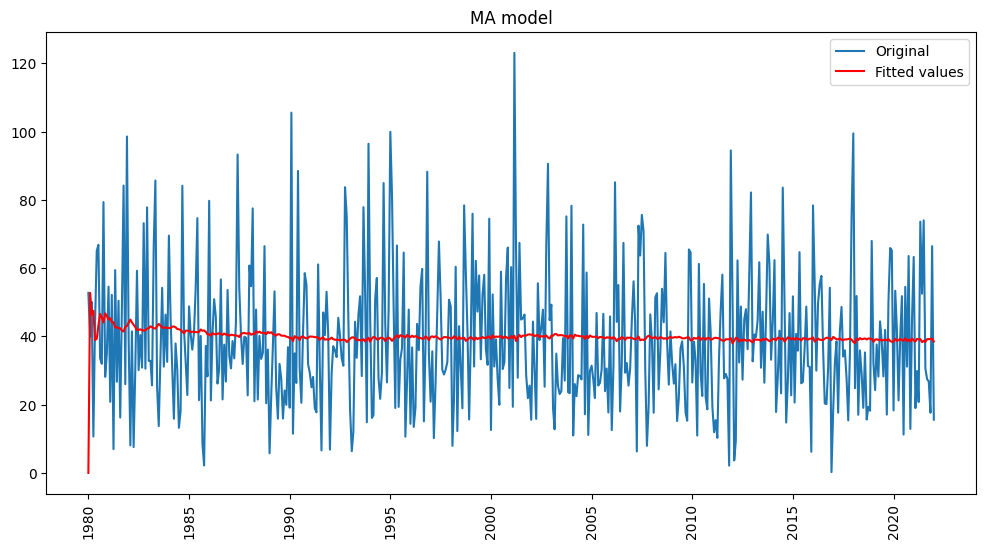

In [439]:
# Modèle MA
model_MA = ARIMA(X_train, order=(0, 1, 2))  
results_MA = model_MA.fit()

# Préparer la visualisation pour le modèle MA
plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['RR'], label='Original')
plt.plot(train_df['date'], results_MA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('MA model')
plt.legend()
plt.show()

c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19.646361541320932


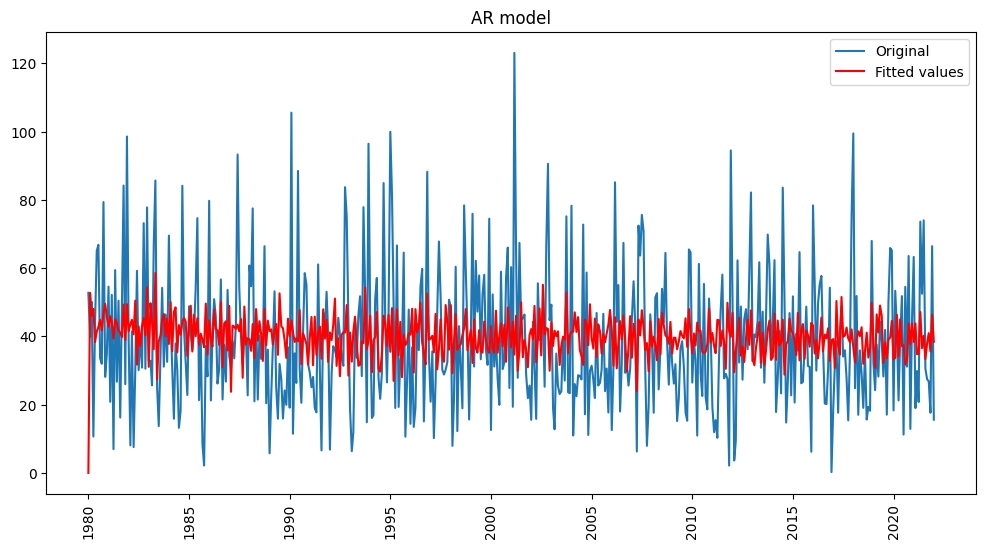

In [440]:
# Modèle ARIMA
model_ARIMA = ARIMA(X_train, order=(12, 1, 24))  
results_ARIMA = model_ARIMA.fit()

# Calculer le RMSE pour le modèle AR
rmse = sqrt(mean_squared_error(X_train, results_ARIMA.fittedvalues))
print(rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_df['date'], train_df['RR'], label='Original')
plt.plot(train_df['date'], results_ARIMA.fittedvalues, color='red', label='Fitted values')
plt.xticks(rotation=90)
plt.title('AR model')
plt.legend()
plt.show()

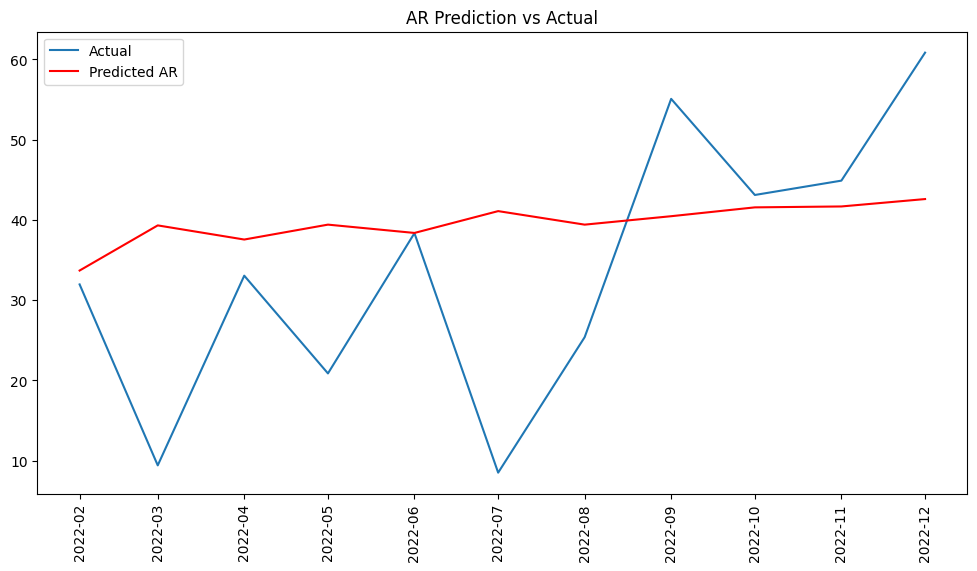

In [441]:
# Prédictions avec le modèle AR
predictions_AR = results_ARIMA.forecast(steps=test_size)

# Préparer la visualisation des prédictions AR vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(test_df['date'], X_test, label='Actual')
plt.plot(test_df['date'], predictions_AR, color='red', label='Predicted AR')
plt.xticks(rotation=90)
plt.title('AR Prediction vs Actual')
plt.legend()
plt.show()

In [442]:
X_test.shape

(11,)

In [443]:
history = [x for x in X_train]
predictions = list()


# walk-forward validation
for t in range(11):
    model = ARIMA(history, order=(12,1,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    obs = X_test.iloc[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=' + str(yhat) +', expected=' + str(obs))

c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=30.520354837471466, expected=31.96609195402299


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=42.44472720511822, expected=9.418435754189945


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=36.28002694780697, expected=33.055151515151515


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=45.64717362940288, expected=20.875694444444445


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=38.30307126389356, expected=38.35352112676056


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=44.39620956613069, expected=8.51063829787234


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=38.110355733228516, expected=25.391366906474822


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=44.84970891473072, expected=55.087857142857146


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=41.05402595596763, expected=43.11134751773049


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=37.987519030230786, expected=44.8972027972028
predicted=45.77633254128629, expected=60.84610778443113


c:\Users\addel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [444]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(X_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.965


C:\Users\addel\AppData\Local\Temp\ipykernel_36500\572179233.py:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates_corrected = pd.date_range(start=last_date, periods=11, freq='M', closed='right')
C:\Users\addel\AppData\Local\Temp\ipykernel_36500\572179233.py:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=last_date, periods=11, freq='M', closed='right')


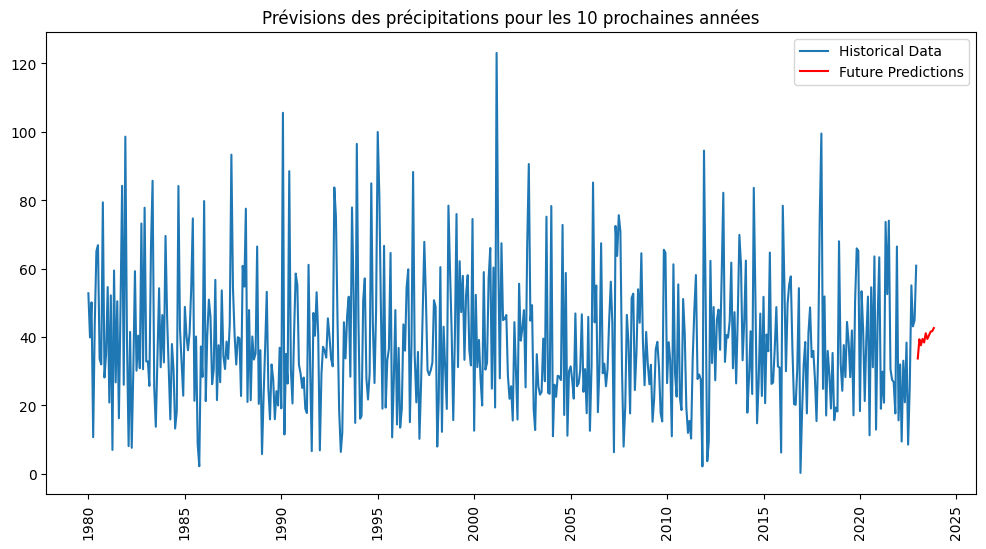

(          date  RR_predicted
 505 2022-12-31     33.696840
 506 2023-01-31     39.320935
 507 2023-02-28     37.559012
 508 2023-03-31     39.416411
 509 2023-04-30     38.380243,
           date  RR_predicted
 511 2023-06-30     39.414576
 512 2023-07-31     40.465718
 513 2023-08-31     41.567724
 514 2023-09-30     41.680614
 515 2023-10-31     42.602205)

In [447]:
last_date = aggregated_df['date'].max()
future_dates_corrected = pd.date_range(start=last_date, periods=11, freq='M', closed='right')
future_dates = pd.date_range(start=last_date, periods=11, freq='M', closed='right')
future_predictions = results_ARIMA.forecast(steps=11)
future_df_corrected = pd.DataFrame({'date': future_dates_corrected, 'RR_predicted': future_predictions})

plt.figure(figsize=(12, 6))
plt.plot(aggregated_df['date'], aggregated_df['RR'], label='Historical Data')
plt.plot(future_df_corrected['date'], future_df_corrected['RR_predicted'], color='red', label='Future Predictions')
plt.xticks(rotation=90)
plt.title('Prévisions des précipitations pour les 10 prochaines années')
plt.legend()
plt.show()

future_df_corrected.head(), future_df_corrected.tail()


## Prévision Température

In [518]:
temp_data = data.groupby("date").agg({
    'TX': 'sum' 
})

In [519]:
temp_data.dropna()

,TX
date,
1980-01-01,117.7
1980-02-01,413.3
1980-03-01,437.9
1980-04-01,582.4
1980-05-01,850.0
...,...
2022-08-01,3537.3
2022-09-01,2513.6
2022-10-01,2500.4


In [497]:
temp_data = temp_data.reset_index()
temp_data['date'] = pd.to_datetime(temp_data['date'])
temp_data.head(10)
#temp_data.to_csv("Temperature.csv")

,date,TX
0,1980-01-01,117.7
1,1980-02-01,413.3
2,1980-03-01,437.9
3,1980-04-01,582.4
4,1980-05-01,850.0
5,1980-06-01,1016.2
6,1980-07-01,1134.0
7,1980-08-01,1297.3
8,1980-09-01,1184.8
9,1980-10-01,714.0


In [520]:
temp_data.shape

(516, 1)

In [521]:
train_df = temp_data.iloc[0:504]
test_df = temp_data.iloc[504:516]

In [522]:
train_df['Y'] = train_df['TX'].shift(-1)
test_df['Y'] = test_df['TX'].shift(-1)

C:\Users\addel\AppData\Local\Temp\ipykernel_36500\2648690087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Y'] = train_df['TX'].shift(-1)
C:\Users\addel\AppData\Local\Temp\ipykernel_36500\2648690087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Y'] = test_df['TX'].shift(-1)


In [523]:
train_df = train_df.fillna(360)
test_df = test_df.dropna()
test_df

,TX,Y
date,,
2022-01-01,670.0,1057.7
2022-02-01,1057.7,1729.7
2022-03-01,1729.7,1918.3
2022-04-01,1918.3,2808.0
2022-05-01,2808.0,3315.4
2022-06-01,3315.4,3634.9
2022-07-01,3634.9,3537.3
2022-08-01,3537.3,2513.6
2022-09-01,2513.6,2500.4


In [524]:
trainX = train_df.TX.values
trainY = train_df.Y.values
testX = test_df.TX
testY = test_df.Y.values

In [525]:
print(testX)

date
2022-01-01     670.0
2022-02-01    1057.7
2022-03-01    1729.7
2022-04-01    1918.3
2022-05-01    2808.0
2022-06-01    3315.4
2022-07-01    3634.9
2022-08-01    3537.3
2022-09-01    2513.6
2022-10-01    2500.4
2022-11-01    1301.7
Name: TX, dtype: float64


In [526]:
print(trainX)

[ 117.7  413.3  437.9  582.4  850.  1016.2 1134.  1297.3 1184.8  714.
  368.5  113.3   57.3  134.5  513.8  756.9  799.4 1058.  1081.9 1201.
  961.7  674.4  430.   167.6  262.5  271.6  348.9  621.5  816.  1016.8
 1119.   971.7  934.7  593.8  418.7  207.9  231.5   79.7  417.6  531.7
  614.8  975.9 1190.9  986.2  854.9  606.9  341.8  211.4  227.3  184.
  478.3  893.7  771.6 1196.4 1431.8 1299.2  988.   846.   607.5  292.4
 -115.4  326.1  414.6  906.5  921.7 1136.1 1459.1 1336.  1335.5  995.8
  261.4  433.6  196.4   42.4  645.5  694.2 1252.4 1380.6 1615.5 1515.6
 1390.2 1122.1  645.9  298.9  -71.3  328.7  455.9 1212.7 1030.3 1295.8
 1596.5 1685.2 1630.2 1086.3  581.5  562.8  544.6  392.6  553.3 1219.8
 1314.6 1500.2 1771.  1746.4 1372.7 1106.1  501.4  361.   518.4  655.9
 1113.2  882.6 1505.1 1593.3 1775.1 1827.8 1446.  1208.4  595.4  543.7
  469.1  938.3 1068.1  936.2 1500.3 1469.7 1798.8 1839.1 1450.4 1151.9
  470.8   95.   356.3  408.8 1010.4 1028.8 1130.3 1451.2 1893.9 1982.
 1693.5  9

In [528]:
trainX = train_df['TX'].values # Convertit la colonne 'TX' en un tableau numpy
testX = test_df['TX'].values # Convertit la colonne 'TX' en un tableau numpy

# Redimensionner les tableaux pour avoir la forme (n, 1, 1), où n est le nombre de lignes dans chaque ensemble
trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
testX = np.reshape(testX, (testX.shape[0], 1, 1))

In [529]:
model = Sequential()

model.add(LSTM(8, input_shape=(1,1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2, validation_data=(testX, testY))

Epoch 1/10
504/504 - 5s - loss: 3152152.7500 - val_loss: 6117917.0000 - 5s/epoch - 9ms/step
Epoch 2/10
504/504 - 1s - loss: 3149904.5000 - val_loss: 6114472.0000 - 1s/epoch - 3ms/step
Epoch 3/10
504/504 - 1s - loss: 3147656.2500 - val_loss: 6111056.5000 - 1s/epoch - 3ms/step
Epoch 4/10
504/504 - 1s - loss: 3145347.0000 - val_loss: 6105316.5000 - 1s/epoch - 3ms/step
Epoch 5/10
504/504 - 1s - loss: 3140356.0000 - val_loss: 6098601.5000 - 1s/epoch - 3ms/step
Epoch 6/10
504/504 - 1s - loss: 3136545.0000 - val_loss: 6093173.0000 - 1s/epoch - 2ms/step
Epoch 7/10
504/504 - 1s - loss: 3133114.7500 - val_loss: 6088070.0000 - 1s/epoch - 3ms/step
Epoch 8/10
504/504 - 1s - loss: 3129801.2500 - val_loss: 6083039.0000 - 1s/epoch - 2ms/step
Epoch 9/10
504/504 - 1s - loss: 3126535.2500 - val_loss: 6078122.0000 - 1s/epoch - 3ms/step
Epoch 10/10
504/504 - 1s - loss: 3123306.5000 - val_loss: 6073203.5000 - 1s/epoch - 2ms/step


In [530]:
# Prédictions sur le train et le test
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 36ms/step


In [531]:
# Evaluation du modèle : un erreur moyenne de 199 passagers en plus ou en moins
rmse = sqrt(mean_squared_error(testY, testPredict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2464.387


In [532]:
def plot_learning_curves(h):
    losss = h.history['loss']
    val_loss = h.history['val_loss']
    
    plt.title('Loss curves')
    plt.plot(losss, label='train loss')
    plt.plot(val_loss, label='test loss')
    plt.legend(loc="upper right")
    plt.show()

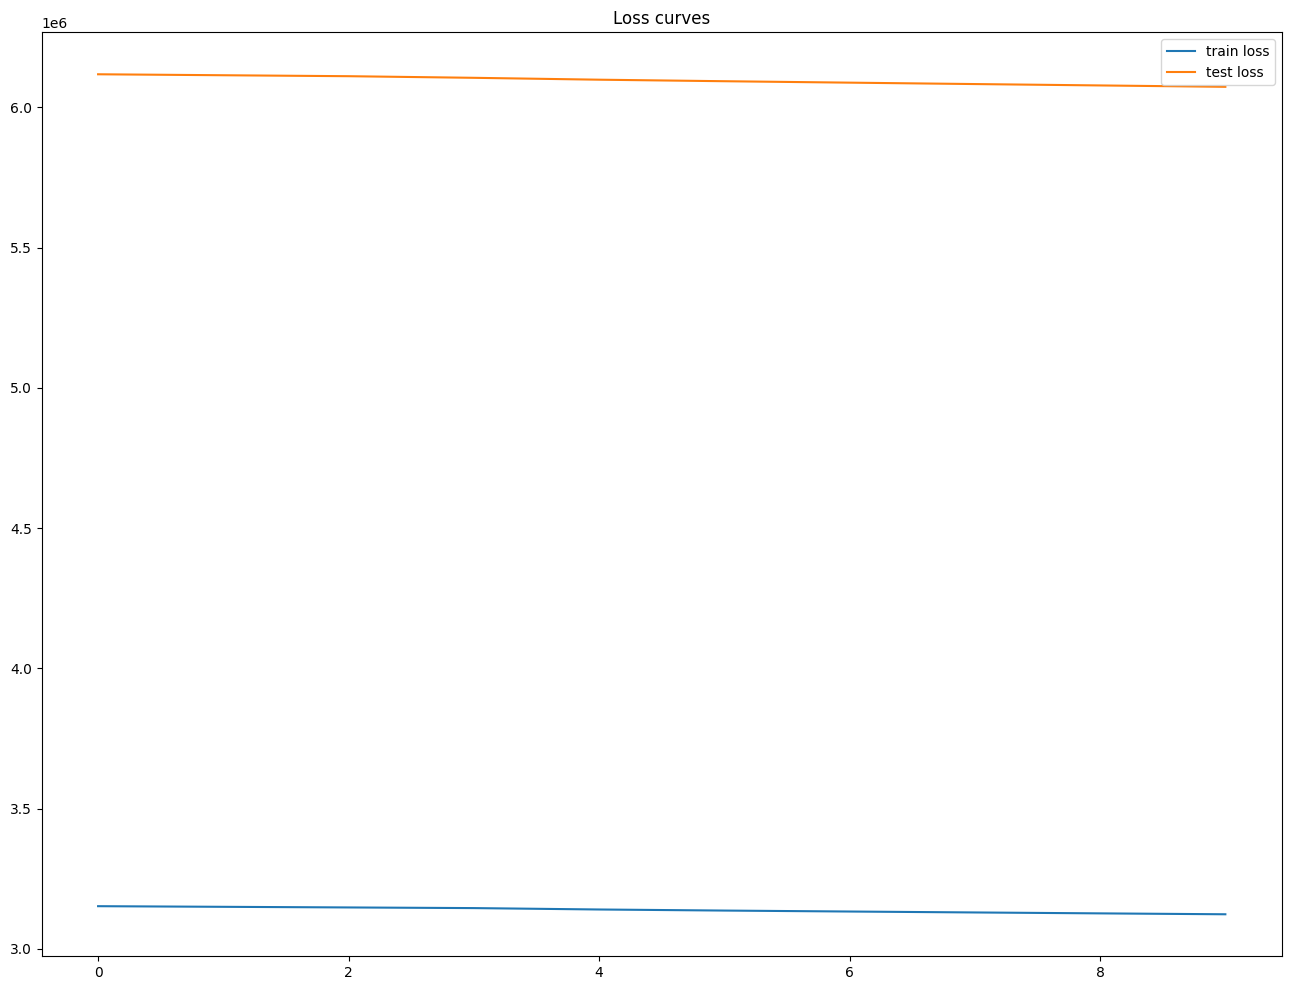

In [533]:
plot_learning_curves(history)

In [534]:
train_df['y_pred'] = trainPredict
test_df['y_pred'] = testPredict

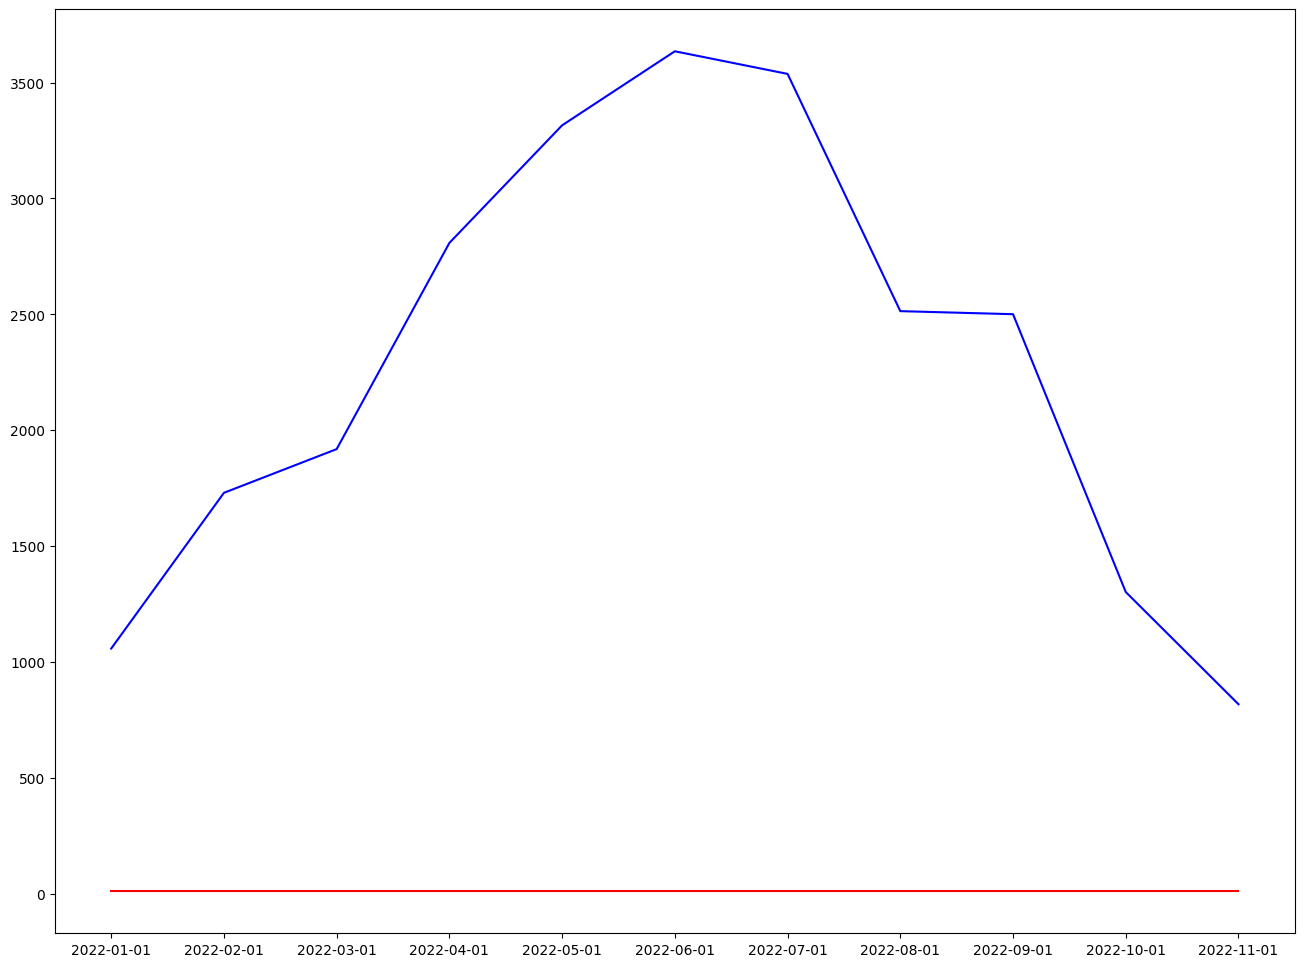

In [535]:
plt.plot(test_df['Y'], color='b')
plt.plot(test_df['y_pred'], color='r')
#plt.plot(testPredictPlot)
plt.show()

In [462]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length), :]
        y = data[i+seq_length, 0]  # Prédire TX
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [463]:
seq_length = 10
X, y = create_sequences(temp_data_scaled, seq_length)

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)

In [464]:
train_size, test_size

(505, 11)

In [465]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Résumé du modèle
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10800     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [466]:
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
13/13 [==============================] - 4s 46ms/step - loss: 0.1897 - val_loss: 0.1163
Epoch 2/5
13/13 [==============================] - 0s 16ms/step - loss: 0.0869 - val_loss: 0.0841
Epoch 3/5
13/13 [==============================] - 0s 15ms/step - loss: 0.0723 - val_loss: 0.0740
Epoch 4/5
13/13 [==============================] - 0s 14ms/step - loss: 0.0668 - val_loss: 0.0695
Epoch 5/5
13/13 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0645


In [472]:
X_test.shape

(11, 10, 3)

1/1 [==============================] - 0s 305ms/step


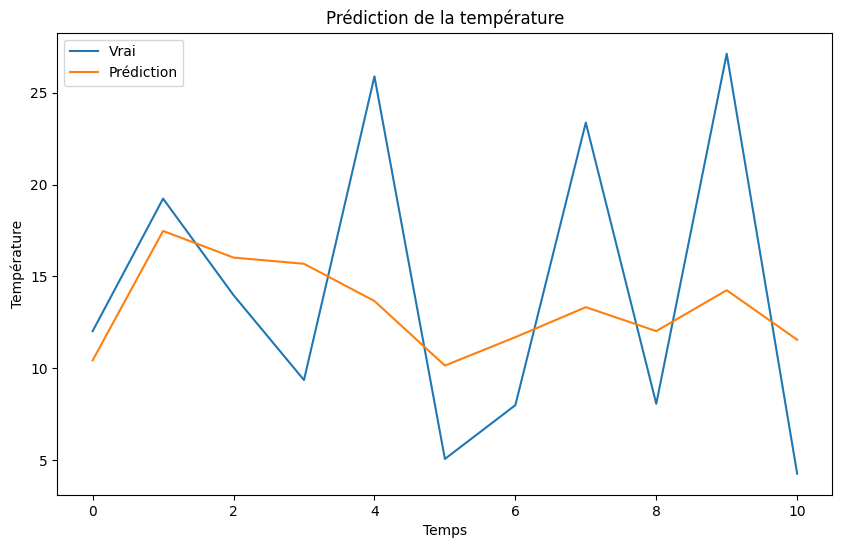

In [467]:
# Prédiction et inversion de la normalisation pour les valeurs réelles et prédites
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test).reshape(-1, 1), np.zeros_like(y_test).reshape(-1, 1)), axis=1))[:, 0]
y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)), axis=1))[:, 0]

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Vrai')
plt.plot(y_pred_inv, label='Prédiction')
plt.title('Prédiction de la température')
plt.xlabel('Temps')
plt.ylabel('Température')
plt.legend()
plt.show()

In [468]:
y_pred_inv.shape

(11,)

In [469]:
temp_data = temp_data.reset_index()
temp_data['date'] = pd.to_datetime(temp_data['date'])
print(temp_data)

          date         TX         TN         TM
0   1980-01-01   1.961667  -4.850000  -1.438333
1   1980-02-01   6.888333  -1.575000   2.663333
2   1980-03-01   7.298333  -0.990000   3.151667
3   1980-04-01   9.871186   0.252542   5.050847
4   1980-05-01  14.912281   4.766071   9.857143
..         ...        ...        ...        ...
511 2022-08-01  26.009559  13.237500  19.627206
512 2022-09-01  18.214493   8.621739  13.418841
513 2022-10-01  18.118841   8.681884  13.398551
514 2022-11-01   9.432609   2.155072   5.793478
515 2022-12-01   4.984146  -0.871166   2.073006

[516 rows x 4 columns]


C:\Users\addel\AppData\Local\Temp\ipykernel_36500\3287059460.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  dates_pred = pd.date_range(start=temp_data['date'].iloc[-1], periods=11, closed='right', freq='Y')


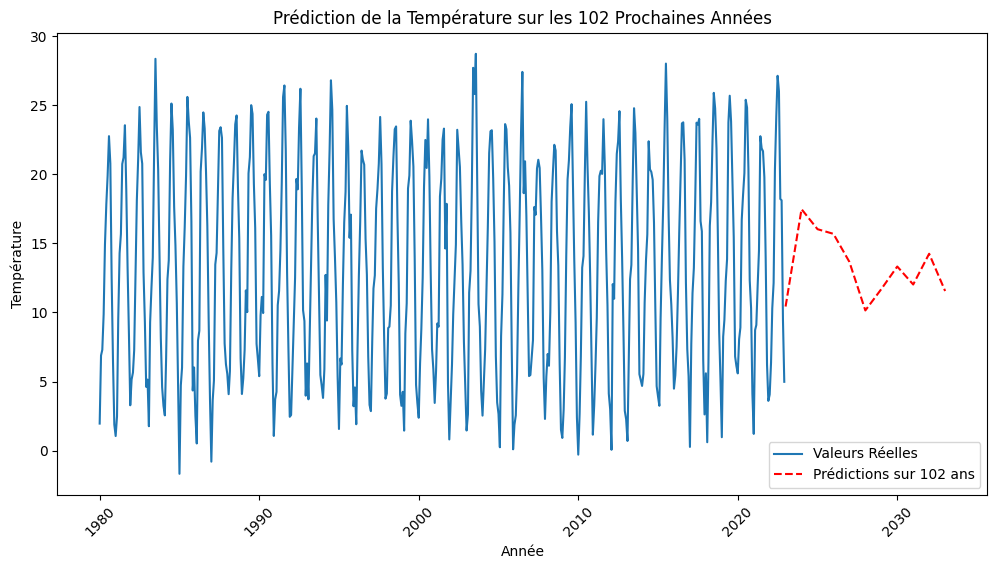

In [470]:
dates_pred = pd.date_range(start=temp_data['date'].iloc[-1], periods=11, closed='right', freq='Y')

# Affichage des données réelles
plt.figure(figsize=(12, 6))
plt.plot(temp_data['date'], temp_data['TX'], label='Valeurs Réelles')

# Affichage des prédictions
plt.plot(dates_pred, y_pred_inv, 'r--', label='Prédictions sur 102 ans')

plt.title('Prédiction de la Température sur les 102 Prochaines Années')
plt.xlabel('Année')
plt.ylabel('Température')
plt.legend()
plt.xticks(rotation=45)
plt.show()